# Script to optimise TOF lens and drift tube voltages at SwissFEL Alvra
- General documentation https://docs.google.com/document/d/1Ll3_WsHzFwuvL-sWgqWQUSYKJRgFG6W7PWY-NJ40WS0/edit?usp=sharing
- User guide ADD WEBSITE
- Comments to christopher.arrell@psi.ch

### Setup

In [10]:
import h5py as h5
import numpy as np
import json
import matplotlib.pyplot as plt
import photodiag
from scipy.optimize import curve_fit
%matplotlib notebook

In [11]:
def LoadData(datafn):
    with h5.File(datafn, 'r') as f:
        pulseIDs = f['pulse_id'][:]
        TOF =-f['SAROP11-PALMK118:CH1_BUFFER/data'][:]
        indexPumped = pulseIDs%2 == 0
    return TOF, pulseIDs
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-((x-mu)**2/(2.*sigma**2)))
def PrepData(DataIn):
    BG = DataIn[0:100].mean()
    return DataIn-BG

### User inputs


In [40]:
energyFrom = 500
energyTo = 2000
energySteps = 1000
CalibrationFn = f'/sf/alvra/data/p17983/res/PhotoDiag/scan_info/2019-07-23_09:02:52.palm_etof'
ScanFn = '/sf/alvra/data/p17983/res/PhotoDiag/scan_info/PALM_resol_1206_scan_info.json'

### Setup and load data

In [57]:
palm = photodiag.PalmSetup(
    channels={'0': 'SAROP11-PALMK118:CH1_BUFFER', '1': 'SAROP11-PALMK118:CH2_BUFFER'},
    noise_range=[0, 250], energy_range=np.linspace(energyFrom, energyTo, energySteps),
)
palm.load_etof_calib(CalibrationFn)

# Load data
with open(ScanFn) as f:
    data = json.load(f)
numFiles = len(data['scan_files'])
LensVolt = data['scan_values']

TOF = []
for i in range(0,numFiles):
    (TOFtmp, pulseIDstmp) = LoadData(str(data['scan_files'][i][0]))
    TOF.append(TOFtmp)
TOF = np.asarray(TOF)
TOF = TOF.mean(axis=1)

LensVoltnp = np.asarray(LensVolt)

### Process data and plot sample data

<IPython.core.display.Javascript object>


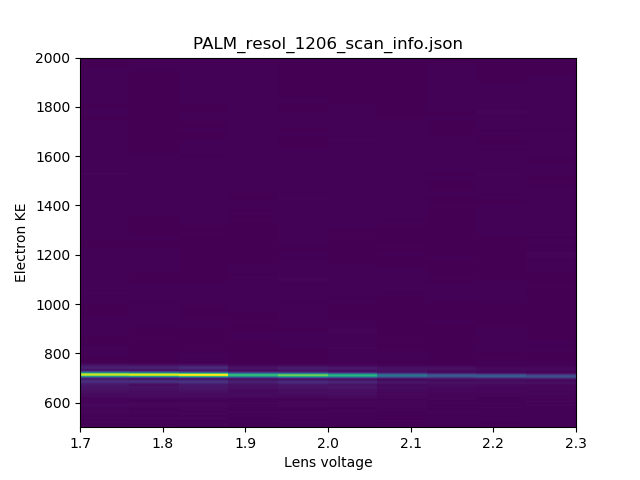

In [58]:
eVInt =[]
eV = palm.energy_range

for i in range(0, TOF.shape[0]):
    tmp = TOF[i,:]
    delays, pulse_lengths, (input_data, lags, corr_res_uncut, corr_results)= palm.process({'0': tmp[np.newaxis,:], '1': tmp[np.newaxis,:]}, debug=True, noise_thr=0, jacobian=False, peak='max')
    eVInt.append(input_data['0'][0,:])
eVInt = np.asarray(eVInt)

plt.figure()
plt.pcolormesh(LensVoltnp[:,1], palm.energy_range,np.transpose(eVInt))
plt.xlabel('Lens voltage')
plt.ylabel('Electron KE')
tmp = plt.title(ScanFn[46:])

### Fit peak intensity and width

<IPython.core.display.Javascript object>


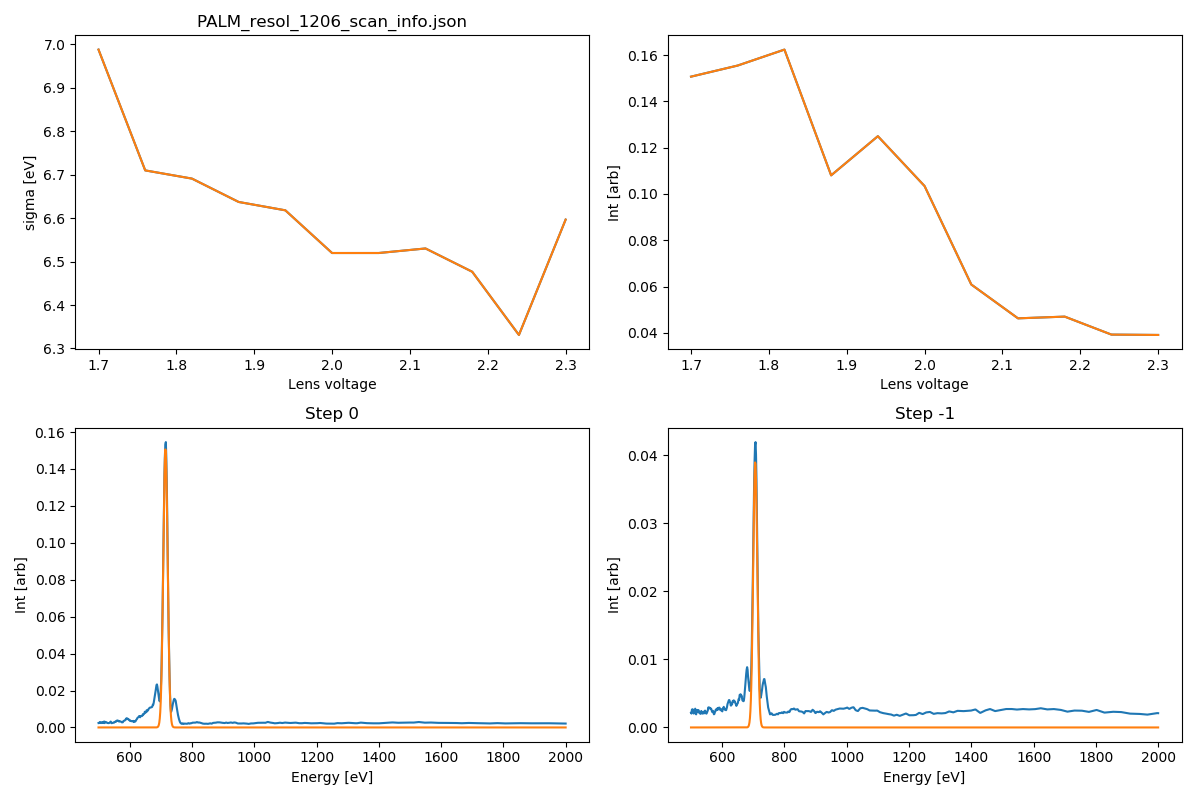

In [59]:
p0 = [0.1, palm.energy_range[np.argmax(eVInt[0,:])],20]
Coeff = []
for i in range(0, TOF.shape[0]):
    try:
        coeff, var_matrix = curve_fit(gauss, eV, PrepData(eVInt[i,:]), p0=p0)
        Coeff.append(coeff)
    except:
        Coeff.append([0,0,0])
Coeff = np.asarray(Coeff)

gridsize = (4,2)
fig=plt.figure(figsize=(12,8))

ax1 = plt.subplot2grid(gridsize, (0,0), colspan=1, rowspan=2)
ax1.plot(LensVolt, np.abs(Coeff[:,2]))
ax1.set_xlabel('Lens voltage')
ax1.set_ylabel('sigma [eV]')
plt.title(ScanFn[46:])

ax2 = plt.subplot2grid(gridsize, (0,1), colspan=1, rowspan=2)
ax2.plot(LensVolt, np.abs(Coeff[:,0]))
ax2.set_xlabel('Lens voltage')
ax2.set_ylabel('Int [arb]')

ax3 = plt.subplot2grid(gridsize, (2,0), colspan=1, rowspan=2)
ax3.plot(palm.energy_range, eVInt[0,:])
ax3.plot(palm.energy_range, gauss(palm.energy_range, *Coeff[0,:]))
ax3.set_title('Step 0')
ax3.set_xlabel('Energy [eV]')
ax3.set_ylabel('Int [arb]')

ax4 = plt.subplot2grid(gridsize, (2,1), colspan=1, rowspan=2)
ax4.plot(palm.energy_range, eVInt[-1,:])
ax4.plot(palm.energy_range, gauss(palm.energy_range, *Coeff[-1,:]))
ax4.set_title('Step -1')
ax4.set_xlabel('Energy [eV]')
ax4.set_ylabel('Int [arb]')
plt.tight_layout()